In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings("ignore")
#sources:
#https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
#https://github.com/chrisjmccormick/LSA_Classification/blob/master/runClassification_LSA.py
#https://www.kaggle.com/c/learn-ai-bbc/data

In [2]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')  

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Read the data



In [3]:
df_train = pd.read_csv('drive/MyDrive/learn-ai-bbc/BBC News Train.csv', index_col = 'ArticleId')

In [4]:
df_train.head(3)

,Text,Category
ArticleId,,
1833,worldcom ex-boss launches defence lawyers defe...,business
154,german business confidence slides german busin...,business
1101,bbc poll indicates economic gloom citizens in ...,business


In [25]:
df_test

,Text
ArticleId,
1018,qpr keeper day heads for preston queens park r...
1319,software watching while you work software that...
1138,d arcy injury adds to ireland woe gordon d arc...
459,india s reliance family feud heats up the ongo...
1020,boro suffer morrison injury blow middlesbrough...
...,...
1923,eu to probe alitalia state aid the european ...
373,u2 to play at grammy awards show irish rock ba...
1704,sport betting rules in spotlight a group of mp...


all classess almost equally distributed

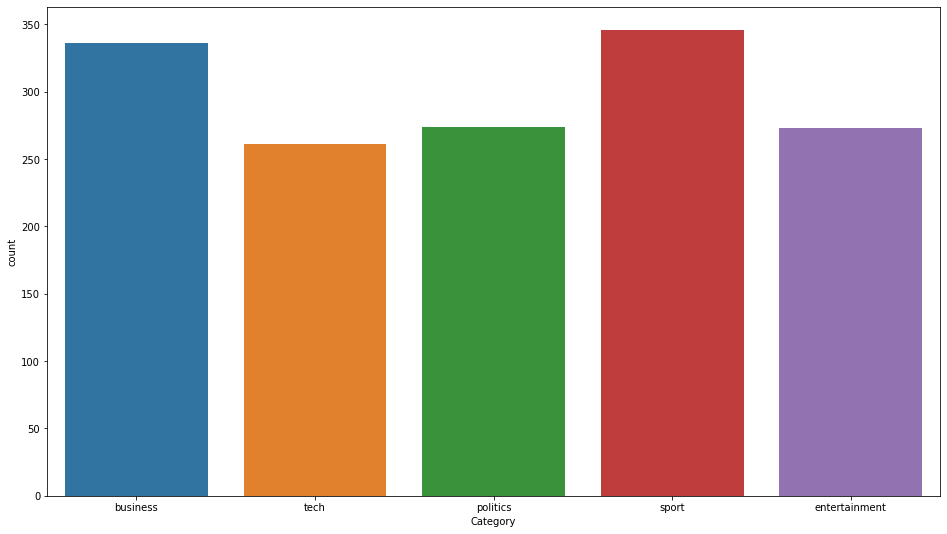

In [5]:
plt.figure(figsize = (16, 9))
sns.countplot('Category', data = df_train)

# Lemmatization with POS tagging


In [6]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    text = word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in text])
   # return [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in text]

df_train['text_lemmatized'] = df_train.Text.apply(lemmatize_text)


# Download stop words from the file

In [7]:
filename = 'drive/MyDrive/learn-ai-bbc/englishST.txt'
with open(filename) as f:
    content = f.readlines()
content = [x.strip() for x in content] 

# TfIdF vectorizer

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words=content)
train_tfid = v.fit_transform(df_train['Text'])




# TruncatedSVD

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(100)
lsa = make_pipeline(svd, Normalizer(copy=False))

X_lsa = lsa.fit_transform(train_tfid)


# Train Test split


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_lsa, df_train['Category'], test_size = 0.3, shuffle = True, random_state = 42)

In [11]:
explained_variance = svd.explained_variance_ratio_.sum()
print("  Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))


  Explained variance of the SVD step: 25%


## Classification


### KNN

In [12]:
k_range = list(range(1,100))
weight_options = ["uniform", "distance"]


param_grid = dict(n_neighbors = k_range, weights = weight_options)

knn = KNeighborsClassifier(metric = 'cosine')

grid = GridSearchCV(knn, param_grid, cv = 10, scoring = 'accuracy')

grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='cosine', metric_params=None,
                                            n_jobs=None, n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [13]:
knn = KNeighborsClassifier(n_neighbors = grid.best_params_['n_neighbors'], weights = grid.best_params_['weights'], metric = 'cosine')

In [14]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='cosine',
                     metric_params=None, n_jobs=None, n_neighbors=29, p=2,
                     weights='distance')

In [15]:
knn.score(X_val, y_val)

0.9753914988814317

In [16]:
knn = KNeighborsClassifier(n_neighbors = grid.best_params_['n_neighbors'], weights = grid.best_params_['weights'], metric = 'cosine')
knn.fit(train_tfid, df_train['Category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='cosine',
                     metric_params=None, n_jobs=None, n_neighbors=29, p=2,
                     weights='distance')

In [17]:
df_test = pd.read_csv('drive/MyDrive/learn-ai-bbc/BBC News Test.csv', index_col = 'ArticleId')
df_sol = pd.read_csv('drive/MyDrive/learn-ai-bbc/BBC News Sample Solution.csv', index_col = 'ArticleId')
test = pd.merge(df_test, df_sol, on = 'ArticleId')

In [18]:
#test['text_lemmatized'] = test.Text.apply(lemmatize_text)
#test_df = v.transform(test['text_lemmatized'])
test_df = v.transform(test['Text'])
test_lsa = lsa.transform(test_df)

In [19]:
predicted = knn.predict(test_df)

In [20]:
submission = pd.DataFrame({
        "ArticleId": test.index,
        "Category": predicted
    })

In [23]:
submission.head(7)

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport
5,51,sport
6,2025,politics


In [ ]:
submission.to_csv('submission.csv', index=False)

In [ ]:
#trained on 70\% of the trainine set
#withot lemmatazation, tfidf - 96.87%
#withot lemmatazation, lsa - 97.687%
#lemmatization, tfifdf - 96.462
#lemmatization, lsa - 97.006
###################################
#all trianing set: 

#lemmatization, tfifdf - 96.190
#lemmatization, lsa - 96.734
#without lemmatazation tfifdf = 96.870
#without lemmatazation, lsa - 97.823